In [2]:
# pip install shap

Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 3.4 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.8 MB 2.1 MB/s eta 0:00:01
   ------------------ --------------------- 1.3/2.8 MB 2.0 MB/s eta 0:00:01
   ------------------ --------------------- 1.3/2.8 MB 2.0 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 1.3 MB/s eta 0:00:01
   ---------------------- ----------------- 1.6/2.8 MB 1.3 MB/s eta 0:00:01
   ------------------------- -------------- 1.8/2.8 MB 1.2 MB/s eta 0:00:01
   ----------------------------- ---------- 2.1/2.8 MB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 1.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.6 MB 5.6 MB/s eta 0:00:02
   ------- -------------------------------- 2.1/11.6 MB 5.1 MB/s eta 0:00:02
   --------- ----------

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import shap

# Load the heart disease dataset
data_path = "D:/MS/Thesis/Datasets/HeartDisease/heart.csv"
heart_data = pd.read_csv(data_path)

# Separate the features and the target variable
X = heart_data.drop("HeartDisease", axis=1)
y = heart_data["HeartDisease"]

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Define preprocessing for numerical data
numerical_transformer = StandardScaler()

# Define preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocess the data
X_transformed = preprocessor.fit_transform(X)

# Extract feature names
num_features = numerical_features.tolist()
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
transformed_feature_names = num_features + cat_features

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42, stratify=y)

# Convert data to PyTorch tensors
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for batching
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
output_size = len(y.unique())
model = NeuralNetwork(input_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

accuracy = correct / total
print(f"Neural Network Accuracy: {accuracy:.4f}")

# # SHAP Interpretation
# explainer = shap.DeepExplainer(model, X_train_tensor)
# shap_values = explainer.shap_values(X_test_tensor)

# # SHAP summary plot
# shap.summary_plot(shap_values, X_test_tensor.numpy(), feature_names=transformed_feature_names)


D:\Anaconda\envs\pytorch_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
D:\Anaconda\envs\pytorch_env\lib\site-packages\torch\autograd\graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/20, Loss: 14.9980
Epoch 2/20, Loss: 11.9877
Epoch 3/20, Loss: 10.7198
Epoch 4/20, Loss: 10.3809
Epoch 5/20, Loss: 10.1739
Epoch 6/20, Loss: 10.0686
Epoch 7/20, Loss: 9.9898
Epoch 8/20, Loss: 9.9171
Epoch 9/20, Loss: 9.8662
Epoch 10/20, Loss: 9.8098
Epoch 11/20, Loss: 9.7490
Epoch 12/20, Loss: 9.6852
Epoch 13/20, Loss: 9.6270
Epoch 14/20, Loss: 9.5688
Epoch 15/20, Loss: 9.5209
Epoch 16/20, Loss: 9.4710
Epoch 17/20, Loss: 9.3764
Epoch 18/20, Loss: 9.3932
Epoch 19/20, Loss: 9.2990
Epoch 20/20, Loss: 9.2023
Neural Network Accuracy: 0.8750


In [2]:
print("X_train_tensor shape:", X_train_tensor.shape)
print("X_test_tensor shape:", X_test_tensor.shape)


X_train_tensor shape: torch.Size([734, 20])
X_test_tensor shape: torch.Size([184, 20])


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import shap

# Load the dataset
data = pd.read_csv('D:/MS/Thesis/Datasets/HeartDisease/heart.csv')

# Separate features and target
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

# Encode categorical variables
le = LabelEncoder()
for col in ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']:
    X[col] = le.fit_transform(X[col])

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Define the neural network
class HeartDiseaseNN(nn.Module):
    def __init__(self, input_dim):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification (logits)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Logits output
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]  # Number of features
model = HeartDiseaseNN(input_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the neural network
epochs = 50
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, axis=1)
    accuracy = (y_pred_classes == y_test_tensor).float().mean().item()
    print(f"Accuracy: {accuracy:.4f}")

# # SHAP explanation
# # Use the same batch size for training and test samples for SHAP
# X_train_sample = X_train_tensor[:64]  # Match batch size to 64
# X_test_sample = X_test_tensor[:64]    # Ensure consistency in batch size

# # Initialize SHAP DeepExplainer
# explainer = shap.DeepExplainer(model, X_train_sample)

# # Calculate SHAP values
# shap_values = explainer.shap_values(X_test_sample)

# # SHAP summary plot
# feature_names = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 
#                  'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 
#                  'Oldpeak', 'ST_Slope']
# shap.summary_plot(shap_values[1], X_test_sample.numpy(), feature_names=feature_names)


Epoch [10/50], Loss: 0.6284
Epoch [20/50], Loss: 0.5361
Epoch [30/50], Loss: 0.4387
Epoch [40/50], Loss: 0.3868
Epoch [50/50], Loss: 0.3673
Accuracy: 0.8587


In [20]:
print(model)

HeartDiseaseNN(
  (fc1): Linear(in_features=11, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
  (relu): ReLU()
)


In [22]:
print(X_train_sample.shape)  # Should be (batch_size, 11)
print(X_test_sample.shape)   # Should be (batch_size, 11)


torch.Size([64, 11])
torch.Size([64, 11])


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import shap

# Load the dataset
data = pd.read_csv('D:/MS/Thesis/Datasets/HeartDisease/heart.csv')

# Separate features and target
X = data.drop('HeartDisease', axis=1)
y = data['HeartDisease']

# Encode categorical variables
le = LabelEncoder()
for col in ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']:
    X[col] = le.fit_transform(X[col])

# Normalize the features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Define the neural network
class HeartDiseaseNN(nn.Module):
    def __init__(self, input_dim):
        super(HeartDiseaseNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)  # Binary classification (logits)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Logits output
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]  # Number of features
model = HeartDiseaseNN(input_dim)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training the neural network
epochs = 50
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluate the model
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_classes = torch.argmax(y_pred, axis=1)
    accuracy = (y_pred_classes == y_test_tensor).float().mean().item()
    print(f"Accuracy: {accuracy:.4f}")

# SHAP explanation with KernelExplainer
# Convert PyTorch tensors to numpy arrays
X_train_sample = X_train  # Use the first 50 training samples as the background dataset
X_test_sample = X_test   # Use the first 20 test samples for SHAP calculation

# Define the prediction function
def predict_fn(data):
    """
    Function that takes input data and outputs probabilities from the model.
    """
    data_tensor = torch.tensor(data, dtype=torch.float32)
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        logits = model(data_tensor)
        probabilities = torch.softmax(logits, dim=1)
    return probabilities.numpy()

# # Initialize SHAP KernelExplainer
# explainer = shap.KernelExplainer(predict_fn, X_train_sample)

# # Calculate SHAP values
# shap_values = explainer.shap_values(X_test_sample)

# # SHAP summary plot
# feature_names = ['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 
#                  'FastingBS', 'RestingECG', 'MaxHR', 'ExerciseAngina', 
#                  'Oldpeak', 'ST_Slope']
# shap.summary_plot(shap_values[1], X_test_sample, feature_names=feature_names)


Epoch [10/50], Loss: 0.6279
Epoch [20/50], Loss: 0.5402
Epoch [30/50], Loss: 0.4429
Epoch [40/50], Loss: 0.3862
Epoch [50/50], Loss: 0.3628
Accuracy: 0.8587


In [29]:
explainer_shap = shap.Explainer(predict_fn, X_train_sample, feature_names=feature_names)
shap_values = explainer_shap(X_test_sample)
# # SHAP summary plot (using mean absolute SHAP values for global feature importance)
# shap.summary_plot(shap_values.values, X_test_sample, feature_names=feature_names)

In [36]:
print(X_test_sample.shape)
print(X_train_sample.shape)

(184, 11)
(734, 11)


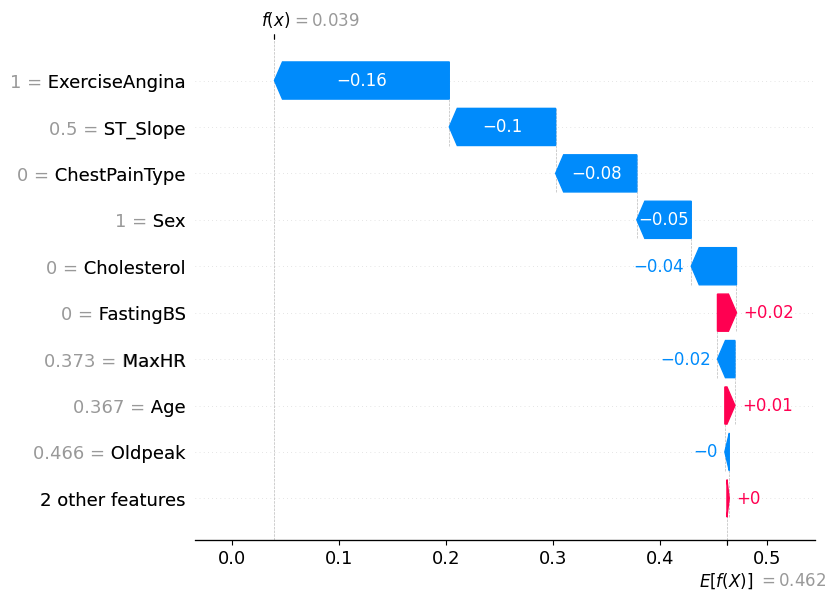

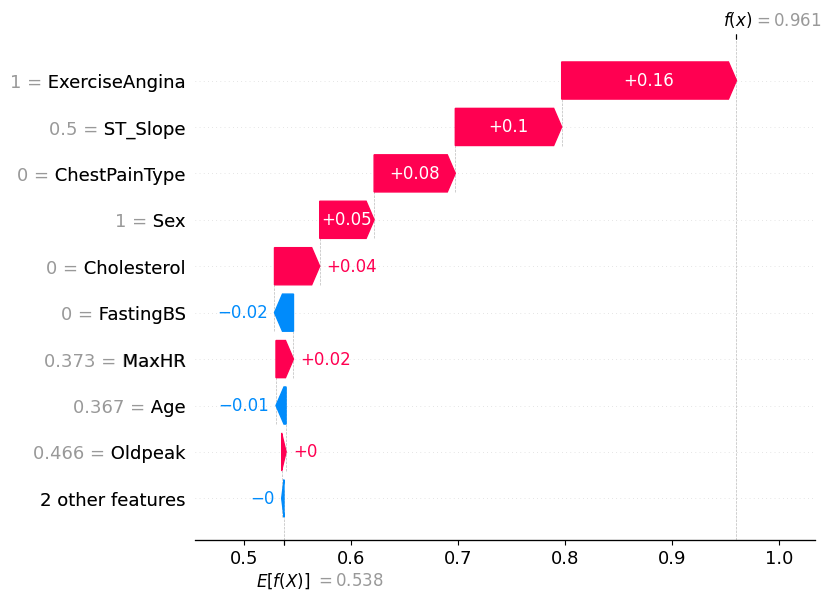

In [37]:
shap.plots.waterfall(shap_values[0,:,0])
shap.plots.waterfall(shap_values[0,:,1])

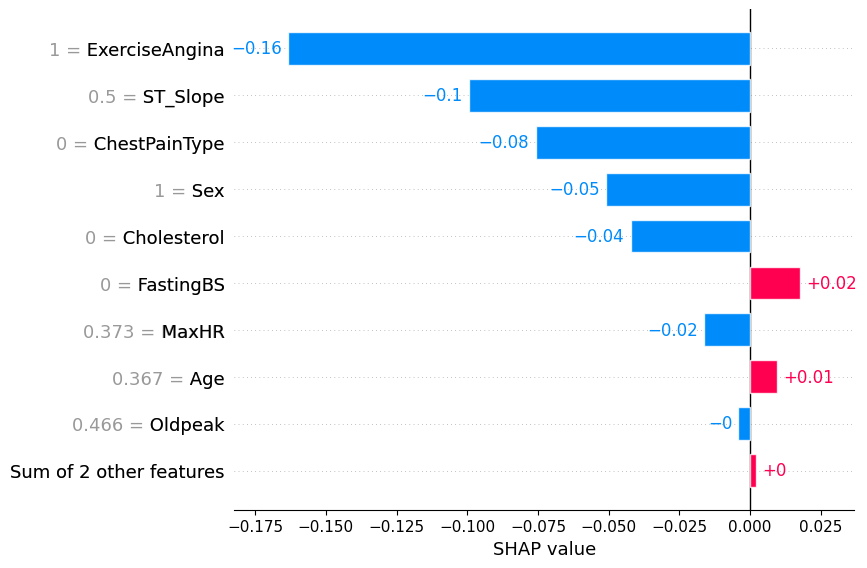

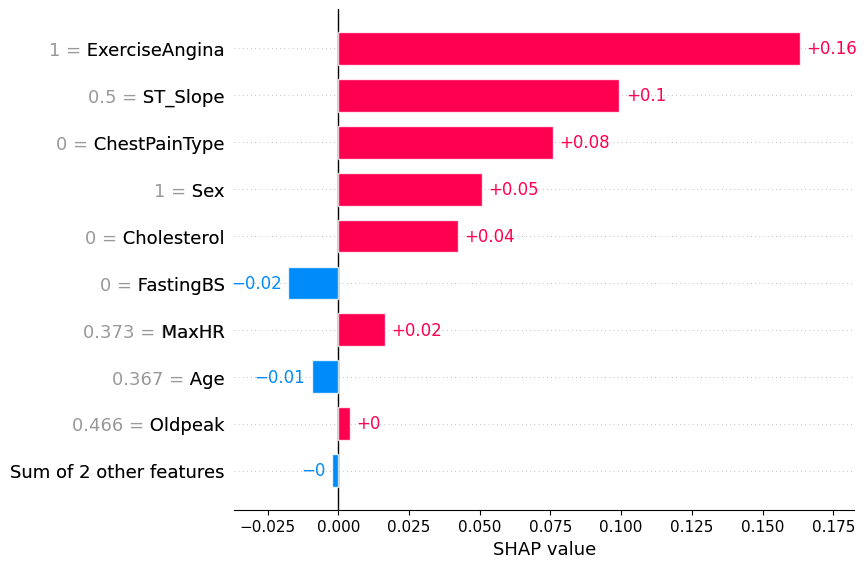

In [38]:
shap.plots.bar(shap_values[0,:,0])
shap.plots.bar(shap_values[0,:,1])

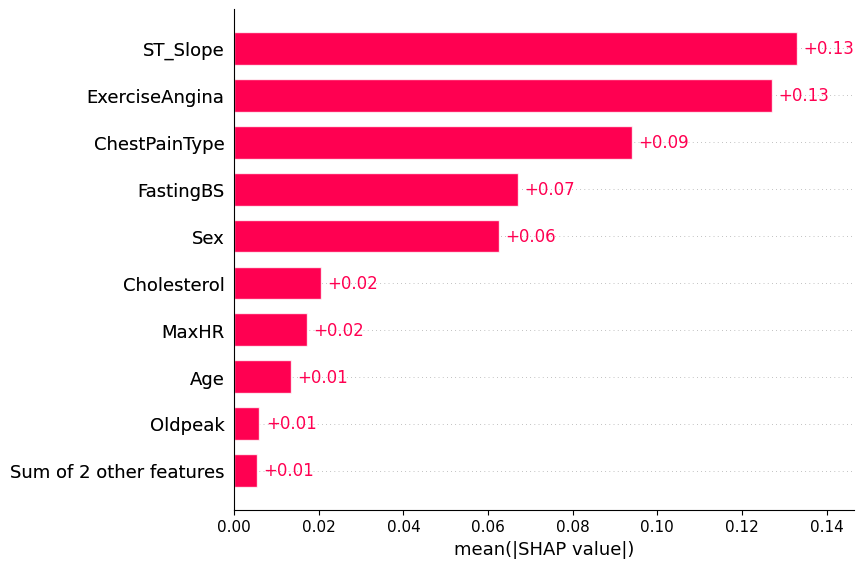

In [39]:
shap.plots.bar(shap_values[:,:,0])

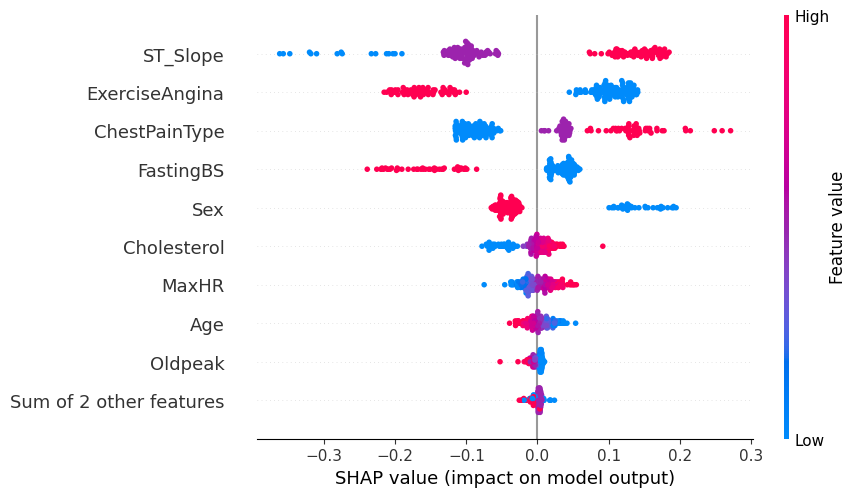

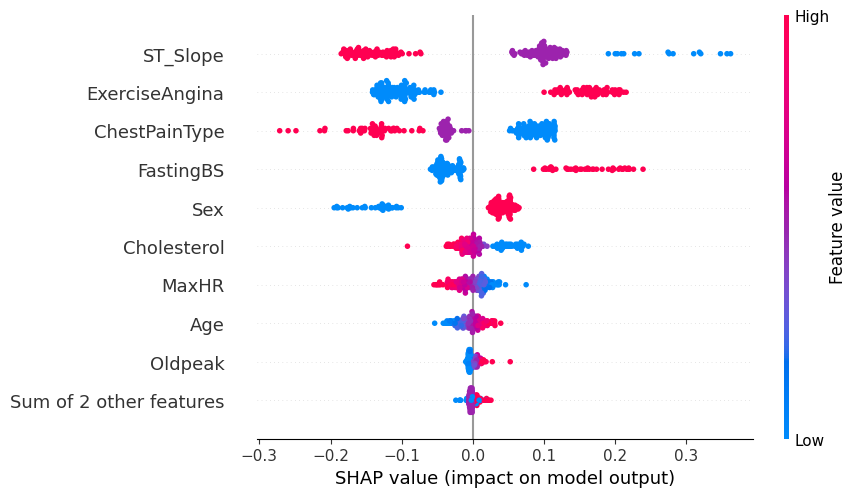

In [40]:
shap.plots.beeswarm(shap_values[:,:,0])
shap.plots.beeswarm(shap_values[:,:,1])

In [20]:
shap.initjs()

In [41]:
shap.plots.force(shap_values[0,:,0])

In [42]:
shap.plots.force(shap_values[0,:,1])

In [43]:
shap.plots.force(shap_values[:,:,0])

In [44]:
shap.plots.force(shap_values[:,:,1])